In [1]:
import torch
import os
import numpy as np

In [2]:
datapath = "N-imagenet/"
train_path = datapath+"extracted_train/"
test_path = datapath+"extracted_val/"

In [4]:
datapath = "N-imagenet/"
train_path = datapath+"train/"
test_path = datapath+"test/"
def random_events(_path):
    classe = torch.randint(0,100,(1,))
    train_class_random = os.listdir(_path+os.listdir(_path)[classe])
    sample = torch.randint(0, len(train_class_random), (1,))
    file = train_class_random[sample]
    folder = file.split("_")[0]
    event_stream = np.load(_path+folder+"/"+file)#, allow_pickle=True)
    return event_stream['event_data'], classe
event_stream, classe = random_events(train_path)

la dimenssion du capteur de l'experience        
        #width = 640
        #height = 480
Ainsi, imagenet = 224x224
soit je prend comme reference 224x2 x 224x2 = 448x448

In [ ]:
def from_events_to_img(events):
    """
    Convert the event stream to a 2D image using vectorized NumPy operations.
    Works with structured arrays with named fields (x, y, t, p).
    """
    # Create an empty image
    img = np.zeros((2, 448, 448), dtype=np.float32)
    
    # Filter valid events based on coordinates
    valid_mask = ((events['x'] >= 96) & 
                  (events['x'] < 544) & 
                  (events['y'] >= 16) & 
                  (events['y'] < 464))
    
    valid_events = events[valid_mask]
    
    # Extract components
    x = valid_events['x'] - 96
    y = valid_events['y'] - 16
    p = valid_events['p']
    
    # Separate positive and negative polarities
    pos_mask = p > 0
    neg_mask = ~pos_mask
    
    # Update image at respective coordinates
    np.add.at(img[0], (y[pos_mask], x[pos_mask]), 1.0)
    np.add.at(img[1], (y[neg_mask], x[neg_mask]), 1.0)
    
    img /= np.maximum(np.max(np.abs(img), axis=(1, 2)), 1e-3)[:, np.newaxis, np.newaxis]
    
    return img

In [9]:
img = from_events_to_img(event_stream)

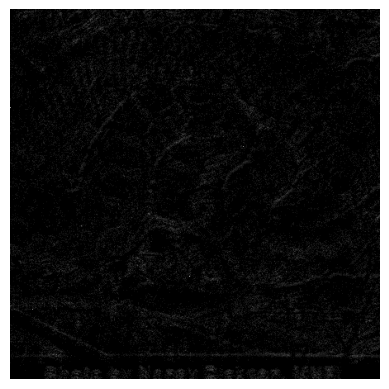

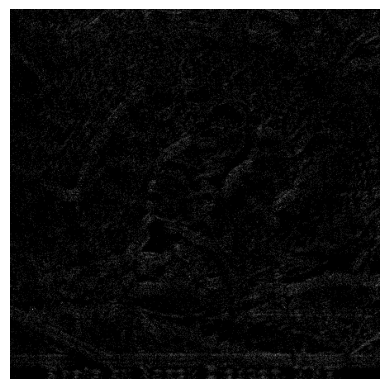

In [113]:
import matplotlib.pyplot as plt
plt.imshow(img[0], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()
plt.imshow(img[1], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

In [ ]:
_path = "N-imagenet_preprocessed/"
_path = _path+"train/"
classe = torch.randint(0,100,(1,))
train_class_random = os.listdir(_path+os.listdir(_path)[classe])
sample = torch.randint(0, len(train_class_random), (1,))
file = train_class_random[sample]
folder = file.split("_")[0]
event_stream = np.load(_path+folder+"/"+file, allow_pickle=True)

In [189]:
event_stream.keys()

KeysView(NpzFile 'N-imagenet_preprocessed/train/n01843383/n01843383_4678.npz' with keys: image, label)

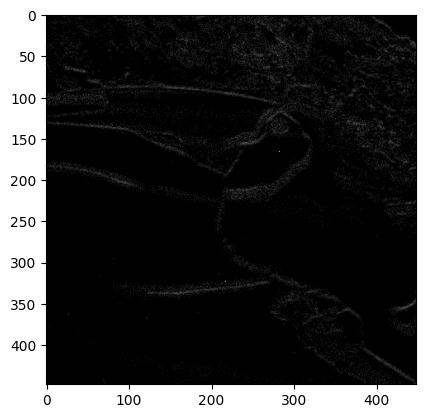

In [190]:
plt.imshow(event_stream['image'][0],vmin=0,vmax=1,cmap='gray')

In [191]:
event_stream['label']

array('n01843383', dtype='<U9')

In [ ]:
def from_events_to_img(events):
    """
    Convert the event stream to a 4-channel 2D image using vectorized NumPy operations.
    Works with structured arrays with named fields (x, y, t, p).
    """
    import numpy as np
    
    # Image dimensions
    H, W = 448, 448
    
    # Create an empty image (4 channels: pos_count, pos_time, neg_count, neg_time)
    img = np.zeros((4, H, W), dtype=np.float32)
    
    # Filter valid events based on coordinates
    valid_mask = ((events['x'] >= 96) &
                  (events['x'] < 544) &
                  (events['y'] >= 16) &
                  (events['y'] < 464))
    valid_events = events[valid_mask]
    
    # Extract components and adjust coordinates
    x = valid_events['x'] - 96
    y = valid_events['y'] - 16
    p = valid_events['p']
    t = valid_events['t']
    
    # Get time normalization values
    start_time = t[0] if len(t) > 0 else 0
    time_length = t[-1] - start_time if len(t) > 0 and t[-1] > start_time else 1.0
    
    # Separate positive and negative polarities
    pos_mask = p > 0
    neg_mask = ~pos_mask
    
    # Handle positive events
    pos_y, pos_x = y[pos_mask], x[pos_mask]
    pos_t = (t[pos_mask] - start_time) / time_length  # Normalize timestamps
    
    # Handle negative events
    neg_y, neg_x = y[neg_mask], x[neg_mask]
    neg_t = (t[neg_mask] - start_time) / time_length  # Normalize timestamps
    
    # Count events (channel 0 and 2)
    np.add.at(img[0], (pos_y, pos_x), 1.0)  # Positive count
    np.add.at(img[2], (neg_y, neg_x), 1.0)  # Negative count
    
    # Normalize counts
    pos_max = np.max(img[0])
    neg_max = np.max(img[2])
    img[0] /= max(pos_max, 1e-3)
    img[2] /= max(neg_max, 1e-3)
    
    # Create temporary arrays for max timestamp calculation
    pos_time_img = np.zeros((H, W), dtype=np.float32)
    neg_time_img = np.zeros((H, W), dtype=np.float32)
    
    # This mimics scatter_max by using a loop (vectorizing this is challenging in NumPy)
    for i in range(len(pos_y)):
        py, px = pos_y[i], pos_x[i]
        pos_time_img[py, px] = max(pos_time_img[py, px], pos_t[i])
    
    for i in range(len(neg_y)):
        ny, nx = neg_y[i], neg_x[i]
        neg_time_img[ny, nx] = max(neg_time_img[ny, nx], neg_t[i])
    
    # Assign timestamps to channels 1 and 3
    img[1] = pos_time_img
    img[3] = neg_time_img
    
    return img

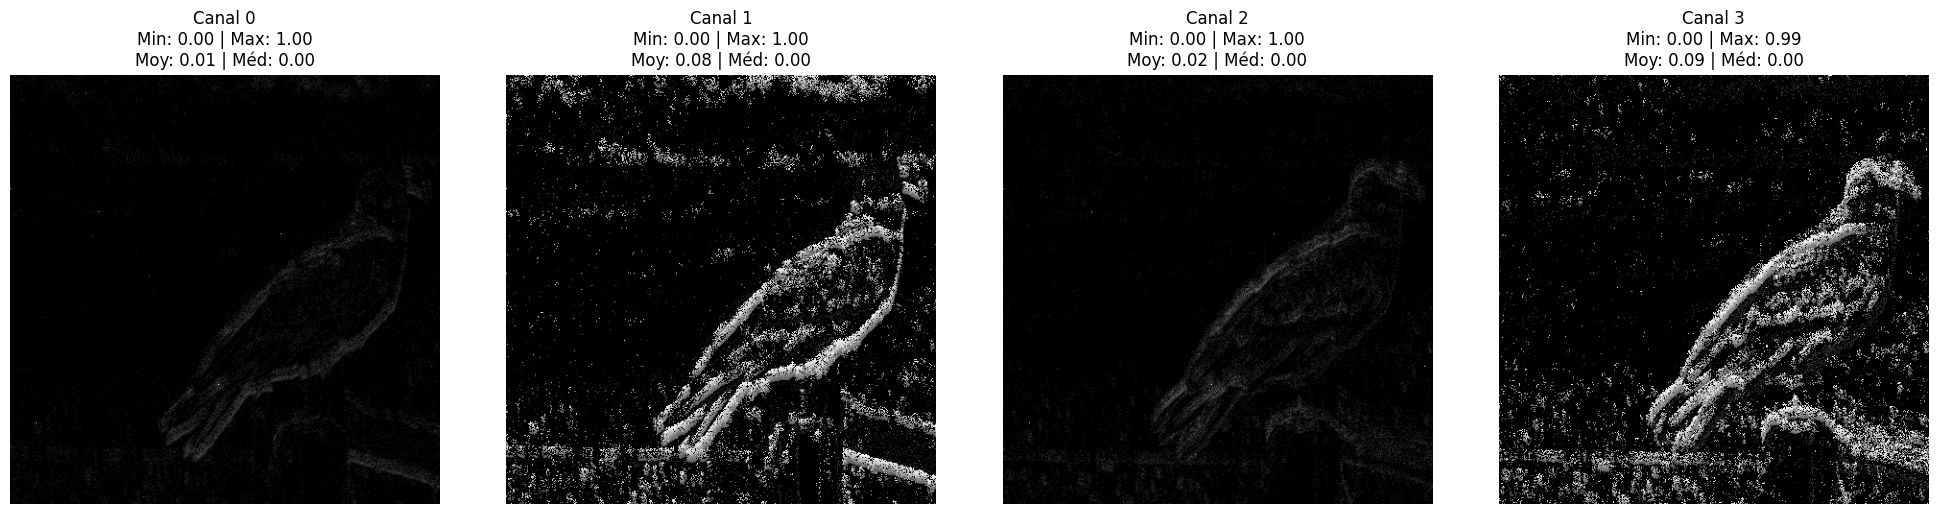

--- Canal 0 ---
Min      : 0.00
Max      : 1.00
Moyenne  : 0.01
Médiane  : 0.00

--- Canal 1 ---
Min      : 0.00
Max      : 1.00
Moyenne  : 0.08
Médiane  : 0.00

--- Canal 2 ---
Min      : 0.00
Max      : 1.00
Moyenne  : 0.02
Médiane  : 0.00

--- Canal 3 ---
Min      : 0.00
Max      : 0.99
Moyenne  : 0.09
Médiane  : 0.00



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
event_stream, classe = random_events(train_path)
# Supposons que ton image est de forme (4, 448, 448)
img = from_events_to_img(event_stream)

# Affichage et statistiques
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
channel_names = ['Canal 0', 'Canal 1', 'Canal 2', 'Canal 3']

for i in range(4):
    channel = img[i]  # (448, 448)
    min_val = channel.min()
    max_val = channel.max()
    mean_val = channel.mean()
    median_val = np.median(channel)

    axes[i].imshow(channel, cmap='gray')
    axes[i].set_title(
        f"{channel_names[i]}\n"
        f"Min: {min_val:.2f} | Max: {max_val:.2f}\n"
        f"Moy: {mean_val:.2f} | Méd: {median_val:.2f}"
    )
    axes[i].axis('off')

plt.tight_layout()
plt.show()

for i in range(4):
    channel = img[i]
    print(f"--- {channel_names[i]} ---")
    print(f"Min      : {channel.min():.2f}")
    print(f"Max      : {channel.max():.2f}")
    print(f"Moyenne  : {channel.mean():.2f}")
    print(f"Médiane  : {np.median(channel):.2f}")
    print()


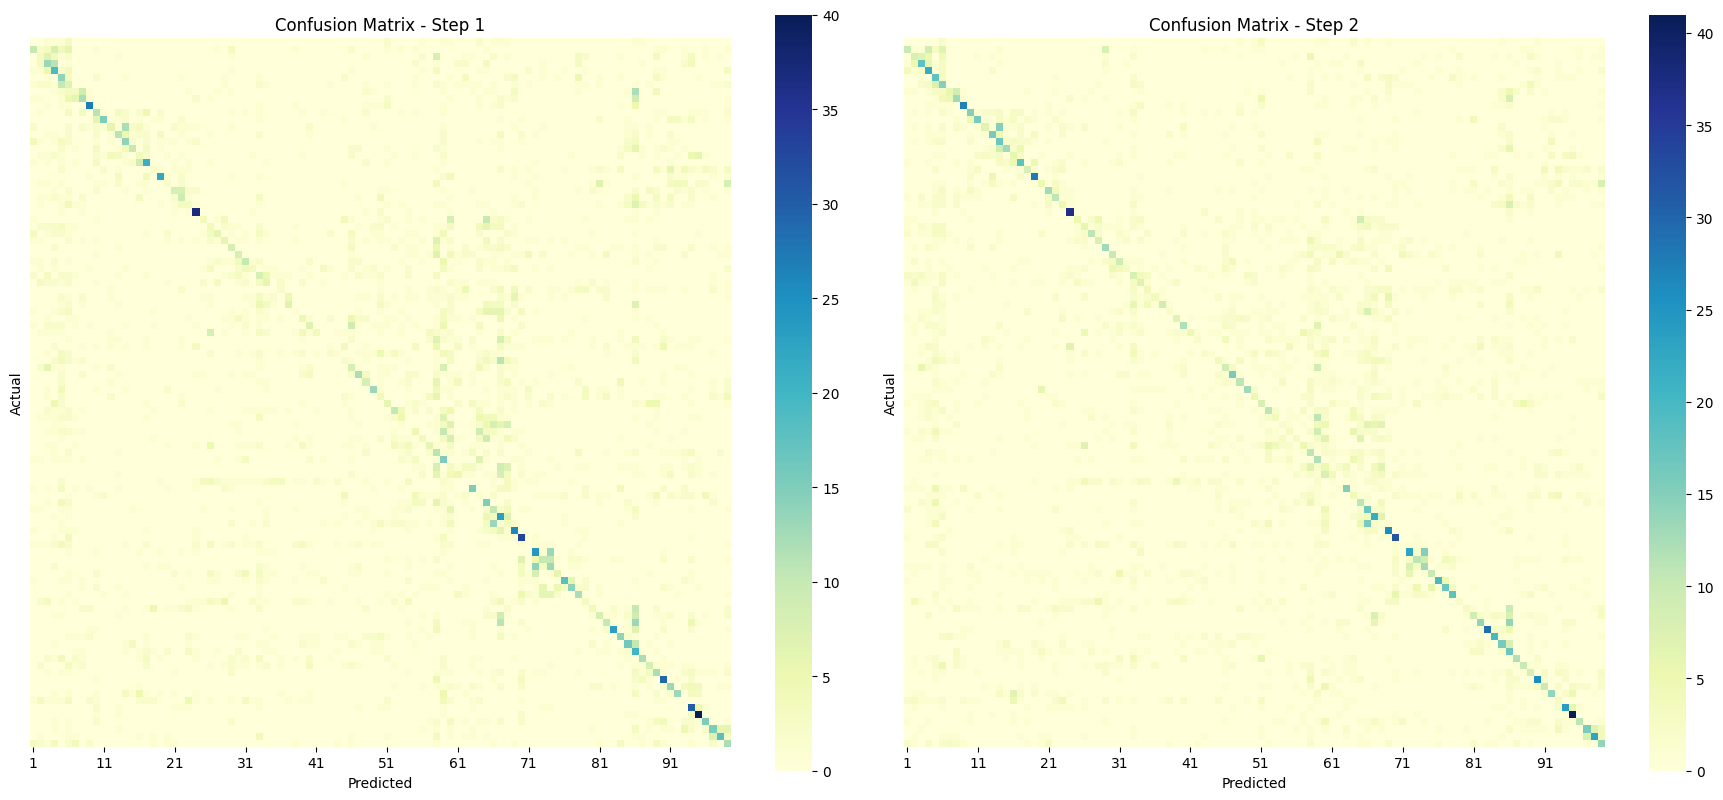

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les deux matrices
df1 = pd.read_csv("recorddata/confusion_matrix_step1.csv", index_col=0)
df2 = pd.read_csv("recorddata/confusion_matrix.csv", index_col=0)

# Création de la figure avec 2 sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Heatmap pour le fichier step 1
sns.heatmap(df1, 
            ax=axes[0], 
            annot=False, 
            cmap="YlGnBu", 
            cbar=True,
            xticklabels=10, 
            yticklabels=False,  # Masquer les labels Y
            square=True)
axes[0].set_title("Confusion Matrix - Step 1")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Heatmap pour le fichier step 25
sns.heatmap(df2, 
            ax=axes[1], 
            annot=False, 
            cmap="YlGnBu", 
            cbar=True,
            xticklabels=10, 
            yticklabels=False,  # Masquer les labels Y aussi
            square=True)
axes[1].set_title("Confusion Matrix - Step 2")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


Visualisation des logs et de la matrice de confusion...
Matrice de confusion chargée depuis recorddata/confusion_matrix_step1.pt
Précision globale: 0.2118


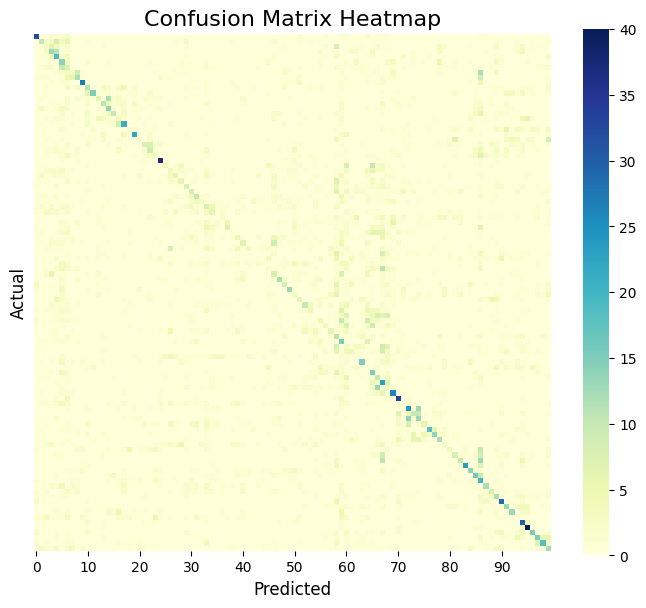

Chargement du fichier: recorddata/Test_26_63_step1.mat


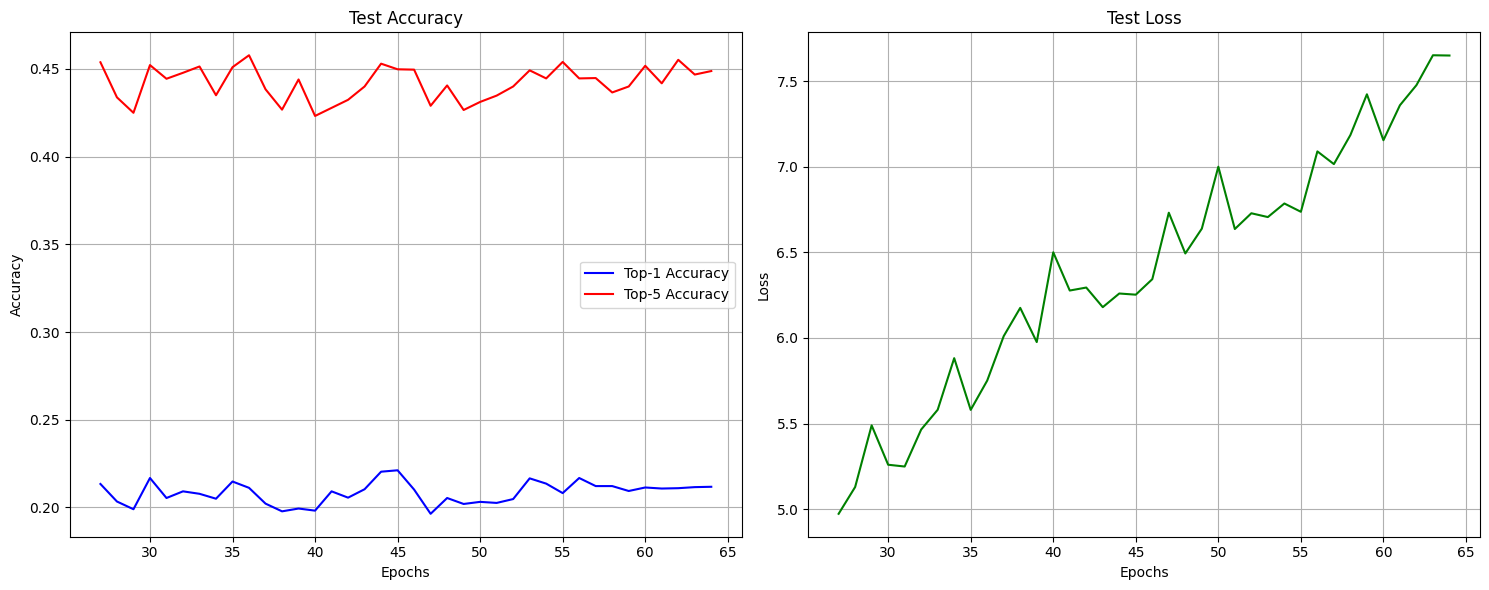

Matrice de confusion chargée depuis recorddata/confusion_matrix.pt
Précision globale: 0.2404


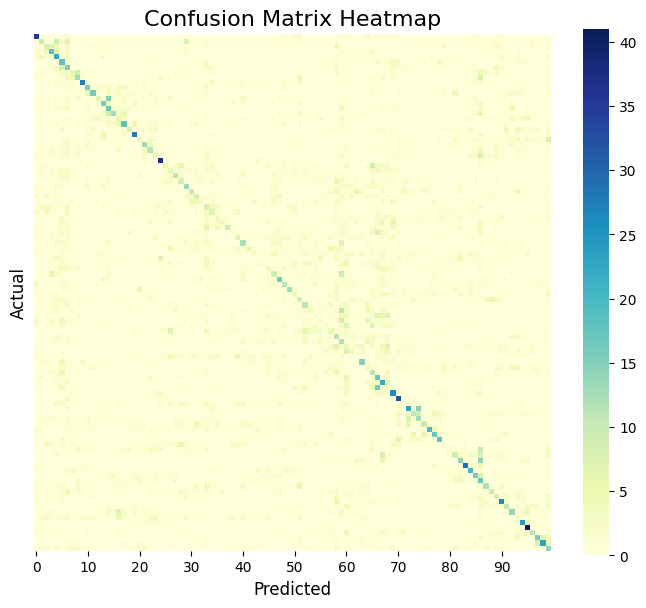

Chargement du fichier: recorddata/Test_0_63_step2.mat


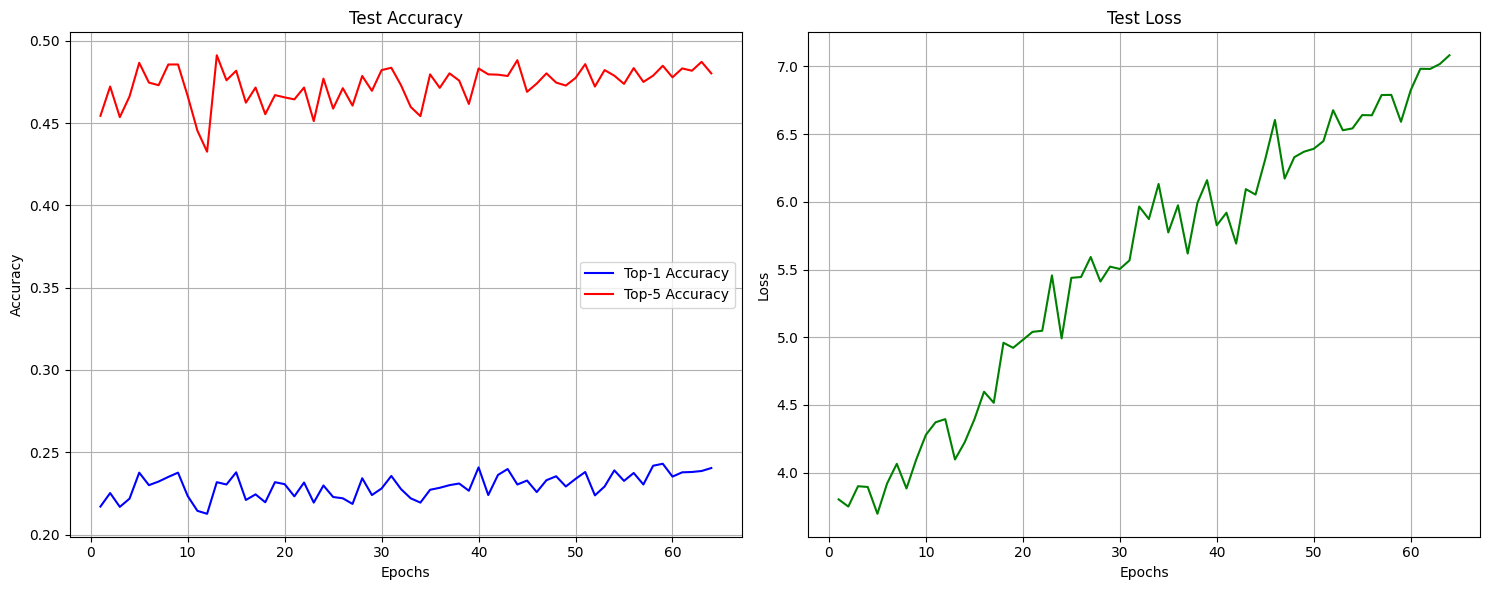

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from scipy.io import loadmat
import seaborn as sns
import pandas as pd

# Chemins des fichiers
save_model_path = 'savemodels/'  # Dossier contenant les fichiers .h5 et .npy
record_path = 'recorddata/'     # Dossier contenant les fichiers .mat
name_suffix = '_step1'          # Suffixe utilisé dans vos fichiers

# Chargement du modèle avec les meilleurs résultats
def load_best_model(net, save_path=save_model_path):
    """Charge le modèle avec la meilleure précision."""
    max_acc_file = os.path.join(save_path, f'max_acc{name_suffix}.npy')
    model_file = os.path.join(save_path, f'max_acc{name_suffix}.h5')
    
    if os.path.exists(max_acc_file) and os.path.exists(model_file):
        max_acc = np.load(max_acc_file).item()
        net.load_state_dict(torch.load(model_file))
        print(f"Modèle chargé avec une précision maximale de: {max_acc:.4f}")
        return net, max_acc
    else:
        print("Fichiers du meilleur modèle non trouvés")
        return None, None

# Chargement et visualisation des logs d'entraînement
def visualize_training_logs(record_path=record_path):
    """Charge et visualise les logs d'entraînement à partir des fichiers .mat"""
    # Chercher le dernier fichier de log
    mat_files = [f for f in os.listdir(record_path) if f.endswith(f'{name_suffix}.mat')]
    if not mat_files:
        print("Aucun fichier .mat trouvé dans le dossier spécifié")
        return None
    
    # Trier par date de modification pour obtenir le plus récent
    mat_files.sort(key=lambda x: os.path.getmtime(os.path.join(record_path, x)), reverse=True)
    latest_mat = os.path.join(record_path, mat_files[0])
    
    print(f"Chargement du fichier: {latest_mat}")
    data = loadmat(latest_mat)
    record_data = data['Record_data']
    
    # Extraire les données
    epochs = record_data[:, 0]
    iterations = record_data[:, 1]
    test_top1 = record_data[:, 2]
    test_topk = record_data[:, 3]
    test_loss = record_data[:, 4]
    
    # Création des graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Graphique de précision
    ax1.plot(epochs, test_top1, 'b-', label='Top-1 Accuracy')
    ax1.plot(epochs, test_topk, 'r-', label='Top-5 Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Test Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Graphique de perte
    ax2.plot(epochs, test_loss, 'g-')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Test Loss')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return record_data

# Visualisation de la matrice de confusion
def visualize_confusion_matrix(name_suffix):
    """Visualise la matrice de confusion à partir d'un fichier .pt ou .csv."""
    try:
        # Essayer de charger depuis un fichier .pt
        confusion_matrix_path = os.path.join(record_path, f'confusion_matrix{name_suffix}.pt')
        if os.path.exists(confusion_matrix_path):
            confusion_matrix = torch.load(confusion_matrix_path)
            if isinstance(confusion_matrix, torch.Tensor):
                confusion_matrix = confusion_matrix.cpu().numpy()
            df = pd.DataFrame(confusion_matrix)
            print(f"Matrice de confusion chargée depuis {confusion_matrix_path}")
        else:
            # Essayer de charger depuis un fichier .csv
            csv_path = os.path.join(record_path, f'confusion_matrix{name_suffix}.csv')
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path, index_col=0)
                print(f"Matrice de confusion chargée depuis {csv_path}")
            else:
                print(f"Aucun fichier de matrice de confusion trouvé à {confusion_matrix_path} ou {csv_path}")
                return

        # Calculer l'accuracy
        if isinstance(df, pd.DataFrame):
            accuracy = df.values.diagonal().sum() / df.values.sum()
            print(f"Précision globale: {accuracy:.4f}")

        # Visualisation
        plt.figure(figsize=(7, 6))
        sns.heatmap(df, 
                    annot=False,
                    cmap="YlGnBu",
                    cbar=True,
                    xticklabels=10,
                    yticklabels=False,  # Masquer les labels sur l'axe Y
                    square=True)

        plt.title("Confusion Matrix Heatmap", fontsize=16)
        plt.xlabel("Predicted", fontsize=12)
        plt.ylabel("Actual", fontsize=12)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Erreur lors de la visualisation de la matrice de confusion: {e}")

# Exemple d'utilisation
if __name__ == "__main__":
    print("Visualisation des logs et de la matrice de confusion...")
    visualize_confusion_matrix("_step1")
    visualize_training_logs()
    visualize_confusion_matrix("")
    name_suffix = "_step2"
    visualize_training_logs()